<a href="https://colab.research.google.com/github/kat-le/cmpe255-assignment4/blob/main/semma_rossman_store_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SEMMA on Kaggle’s Rossmann Store Sales

**Goal:** Forecast daily store Sales so you can plan staffing, inventory, and promotions.

## SEMMA framing

**Sample** — load/join train.csv + store.csv, downsample stores/dates, and make a time-aware train/validation split.

**Explore** — quick distributions/plots (month, day-of-week, promos) to see signal and gaps.

**Modify** — engineer features (date parts, Promo2Active, CompMonths, distances), clean missing values, log-transform the target.

**Model** — one-hot + LightGBM (or RandomForest fallback) to learn non-linear effects.

**Assess** — MAE/RMSE/RMSPE on a hold-out window, residual plot, feature importance; then refit on all data and write a Kaggle-ready submission.csv.

In [ ]:
# Small helpers and a consistent RNG seed
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os, math, warnings, random
warnings.filterwarnings("ignore")

SEED = 42
def set_seed(s=SEED):
    np.random.seed(s); random.seed(s)

def ok(msg="OK"): print(f"✅ {msg}")
def expect(cond, msg="Check failed"):
    assert bool(cond), f"❌ {msg}"; return True

set_seed()
ok("Environment ready")


✅ Environment ready


## Imports (+ LightGBM detection)

* Imports LightGBM if available; otherwise you’ll use RandomForest.
  - Tree models handle non-linearities and interactions (promo × day × store type) much better than linear baselines.
* Pulls sklearn transformers/metrics.

In [ ]:
# If LightGBM isn't available, this will still run using RandomForest
try:
    import lightgbm as lgb
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
ok(f"Imports done | LightGBM={HAS_LGBM}")

✅ Imports done | LightGBM=True


## SAMPLE

Load & integrate train/test with store

* Reads CSVs with Date parsed.
* Normalizes some columns (StateHoliday to strings, fills Open in test).
* Joins store.csv to both train/test to add metadata (distance, type, assortment, competition, promo2 info).
  - Integration is required: most predictive signal (competition, Promo2) lives in store.csv.

In [ ]:
train = pd.read_csv("train.csv", parse_dates=["Date"])
test  = pd.read_csv("test.csv",  parse_dates=["Date"])
store = pd.read_csv("store.csv")
print("Train:", train.shape)
print("Test:", test.shape)
print("Store:", store.shape)

Train: (1017209, 9)
Test: (41088, 8)
Store: (1115, 10)


In [ ]:
# Standardize dtypes / strings
for df in (train, test):
    df["StateHoliday"] = df["StateHoliday"].astype(str)
    df["Open"] = df["Open"].fillna(1).astype(int)
    df["SchoolHoliday"] = df["SchoolHoliday"].astype(int)
    df["Promo"] = df["Promo"].astype(int)

# Merge store info
train = train.merge(store, on="Store", how="left")
test  = test.merge(store, on="Store",  how="left")

print(train.shape)
print(test.shape)

(1017209, 18)
(41088, 17)


Optional downsample by stores / dates for fast iteration.

* Limits to N stores or ends at a cut-off date.

* Drops closed days in training (Rossmann policy: sales are 0 if Open=0).

In [ ]:
N_STORES = None
END_DATE = None

df_tr = train.copy()
df_te = test.copy()

if N_STORES:
    top_stores = (df_tr["Store"].value_counts()
                  .sort_values(ascending=False).head(N_STORES).index)
    df_tr = df_tr[df_tr["Store"].isin(top_stores)]
    df_te = df_te[df_te["Store"].isin(top_stores)]

if END_DATE:
    df_tr = df_tr[df_tr["Date"] <= pd.to_datetime(END_DATE)]
    df_te = df_te[df_te["Date"] <= pd.to_datetime(END_DATE)]

df_tr = df_tr[df_tr["Open"] == 1]

print("Train:", df_tr.shape)
print("Test:", df_te.shape)

Train: (844392, 18)
Test: (41088, 17)


## Explore

Quick univariate/multivariate checks.

Plots:

* Sales histogram (skewed right; later we log-transform).

* Average sales by Month (seasonality).

* Average sales by Promo (uplift from promotions).

* Average sales by Day-of-Week (weekly pattern).

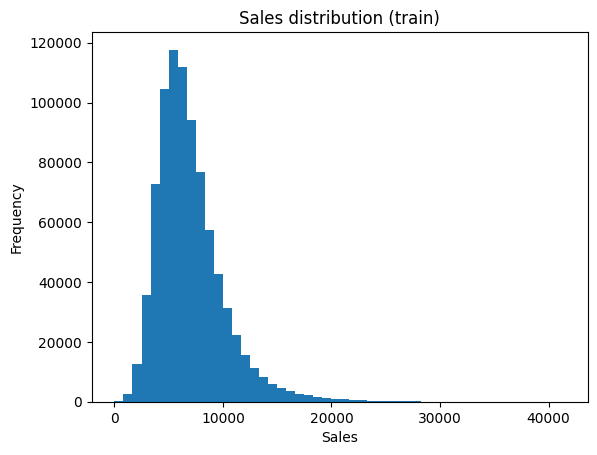

In [ ]:
ax = df_tr["Sales"].plot(kind="hist", bins=50, title="Sales distribution (train)");
ax.set_xlabel("Sales"); plt.show()

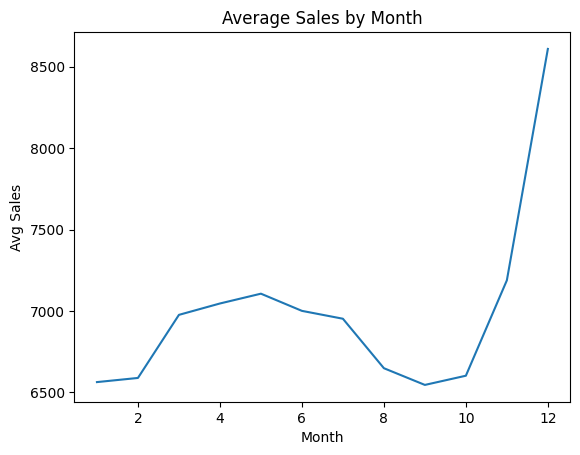

In [ ]:
by_month = df_tr.assign(Month=df_tr["Date"].dt.month).groupby("Month")["Sales"].mean()
by_month.plot(title="Average Sales by Month"); plt.ylabel("Avg Sales"); plt.show()

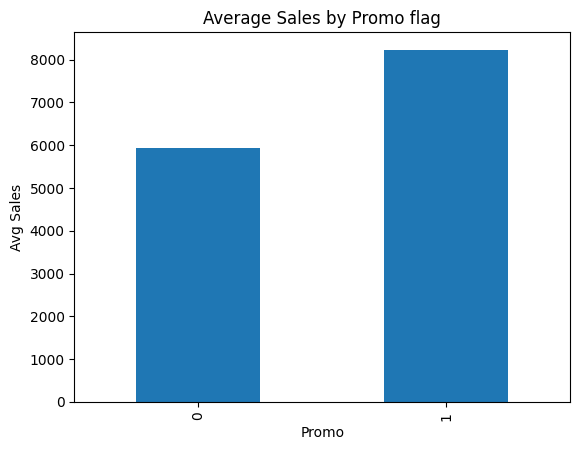

In [ ]:
by_promo = df_tr.groupby("Promo")["Sales"].mean()
by_promo.plot(kind="bar", title="Average Sales by Promo flag"); plt.ylabel("Avg Sales"); plt.show()

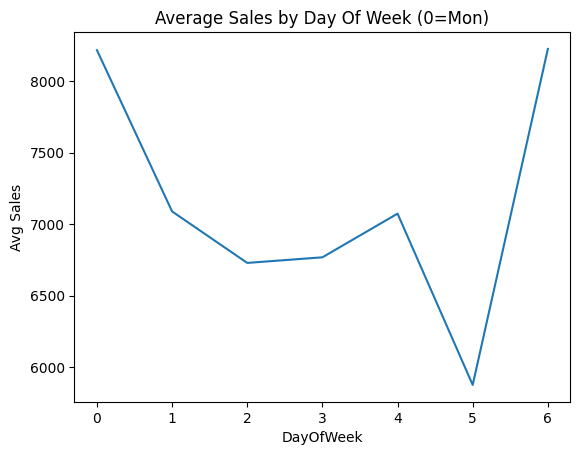

In [ ]:
by_dow = df_tr.assign(DayOfWeek=df_tr["Date"].dt.dayofweek)\
              .groupby("DayOfWeek")["Sales"].mean()
by_dow.plot(title="Average Sales by Day Of Week (0=Mon)"); plt.ylabel("Avg Sales"); plt.show()

## Modify

Feature engineering (date parts, Promo2 active, competition age)

* Adds date parts: Year/Month/Week/Day, DoW, IsWeekend.
* Builds CompMonths = months since competitor opened (bounded at 0).
* Builds Promo2Active flag based on start week/year and monthly intervals.
* Fills CompetitionDistance (median) and cleans StateHoliday labels.
* Creates Sales_log = log1p(Sales) for a stabler learning target.
* Defines the feature lists:
  - CATS (categoricals to one-hot) e.g., StoreType, Assortment, StateHoliday, Promo, Promo2Active, DayOfWeek.
  - NUMS (numerics pass-through) e.g., CompetitionDistance, CompMonths, Year/Month/Week/Day, IsWeekend.

In [ ]:
# Helpers to compute Promo2 active by month names
MONTH_NAME = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
def promo2_active(row_date, promo2, since_year, since_week, interval):
    if promo2 != 1 or pd.isna(since_year) or pd.isna(since_week) or pd.isna(interval):
        return 0
    # promo2 start date (approximate first day of ISO week)
    try:
        start = pd.to_datetime(f"{int(since_year)}-W{int(since_week):02d}-1", format="%G-W%V-%u", errors="coerce")
    except Exception:
        start = pd.NaT
    if pd.isna(start) or row_date < start:
        return 0
    months = [m.strip() for m in str(interval).split(",")]
    return int(MONTH_NAME[row_date.month] in months)

def build_features(df):
    d = df.copy()
    # Date parts
    d["Year"]  = d["Date"].dt.year
    d["Month"] = d["Date"].dt.month
    d["Week"]  = d["Date"].dt.isocalendar().week.astype(int)
    d["Day"]   = d["Date"].dt.day
    d["DoW"]   = d["Date"].dt.dayofweek
    d["IsWeekend"] = (d["DoW"]>=5).astype(int)

    # Competition age in months
    comp_year  = d["CompetitionOpenSinceYear"].fillna(0).astype(int)
    comp_month = d["CompetitionOpenSinceMonth"].fillna(0).astype(int).clip(1,12)
    comp_date = pd.to_datetime(dict(year=comp_year, month=comp_month, day=15), errors="coerce")
    d["CompMonths"] = ((d["Date"].dt.year - comp_date.dt.year)*12 + (d["Date"].dt.month - comp_date.dt.month)).clip(lower=0).fillna(0).astype(int)

    # Promo2 active flag
    d["Promo2Active"] = [
        promo2_active(dt, p2, y, w, inter)
        for dt,p2,y,w,inter in zip(d["Date"], d["Promo2"].fillna(0), d["Promo2SinceYear"], d["Promo2SinceWeek"], d["PromoInterval"])
    ]

    # Clean/transform selected columns
    d["CompetitionDistance"] = d["CompetitionDistance"].fillna(d["CompetitionDistance"].median())
    d["StateHoliday"] = d["StateHoliday"].replace({"0":"None","a":"Public","b":"Easter","c":"Christmas"})  # human labels

    # Target transform (log1p improves stability)
    if "Sales" in d.columns:
        d["Sales_log"] = np.log1p(d["Sales"])

    return d

train_fe = build_features(df_tr)
test_fe  = build_features(df_te)

# Features & target
TARGET = "Sales_log"
CATS = ["Store","StoreType","Assortment","StateHoliday","Promo","Promo2","Promo2Active","SchoolHoliday","DayOfWeek"] \
       if "DayOfWeek" in train.columns else ["Store","StoreType","Assortment","StateHoliday","Promo","Promo2","Promo2Active","SchoolHoliday"]
NUMS = ["CompetitionDistance","CompMonths","Year","Month","Week","Day","IsWeekend"]

# X/y and test matrix
X = train_fe[CATS + NUMS].copy()
y = train_fe[TARGET].astype(float).copy()
X_test_final = test_fe[CATS + NUMS].copy()

print("Shapes — X:", X.shape, "| y:", y.shape, "| X_test:", X_test_final.shape)
ok("Feature engineering complete")

Shapes — X: (844392, 16) | y: (844392,) | X_test: (41088, 16)
✅ Feature engineering complete


In [ ]:
train_fe.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,PromoInterval,Year,Month,Week,Day,DoW,IsWeekend,CompMonths,Promo2Active,Sales_log
0,1,5,2015-07-31,5263,555,1,1,None,1,c,...,NaN,2015,7,31,31,4,0,82,0,8.568646
1,2,5,2015-07-31,6064,625,1,1,None,1,a,...,"Jan,Apr,Jul,Oct",2015,7,31,31,4,0,92,1,8.710290
2,3,5,2015-07-31,8314,821,1,1,None,1,a,...,"Jan,Apr,Jul,Oct",2015,7,31,31,4,0,103,1,9.025816
3,4,5,2015-07-31,13995,1498,1,1,None,1,c,...,NaN,2015,7,31,31,4,0,70,0,9.546527
4,5,5,2015-07-31,4822,559,1,1,None,1,a,...,NaN,2015,7,31,31,4,0,3,0,8.481151


In [ ]:
X.head()

,Store,StoreType,Assortment,StateHoliday,Promo,Promo2,Promo2Active,SchoolHoliday,DayOfWeek,CompetitionDistance,CompMonths,Year,Month,Week,Day,IsWeekend
0,1,c,a,None,1,0,0,1,5,1270.0,82,2015,7,31,31,0
1,2,a,a,None,1,1,1,1,5,570.0,92,2015,7,31,31,0
2,3,a,a,None,1,1,1,1,5,14130.0,103,2015,7,31,31,0
3,4,c,c,None,1,0,0,1,5,620.0,70,2015,7,31,31,0
4,5,a,a,None,1,0,0,1,5,29910.0,3,2015,7,31,31,0


## Sample

Time-aware split (hold out the last N days).

* Splits chronologically at a recent cutoff (HOLDOUT_DAYS).

* Prints the date ranges of train vs validation.

In [ ]:
HOLDOUT_DAYS = 42

cutoff = train_fe["Date"].max() - pd.Timedelta(days=HOLDOUT_DAYS)
train_mask = train_fe["Date"] <= cutoff
valid_mask = train_fe["Date"] >  cutoff

X_tr, X_va = X[train_mask], X[valid_mask]
y_tr, y_va = y[train_mask], y[valid_mask]

print("Train range:", train_fe.loc[train_mask,"Date"].min(), "→", train_fe.loc[train_mask,"Date"].max())
print("Valid range:", train_fe.loc[valid_mask,"Date"].min(), "→", train_fe.loc[valid_mask,"Date"].max())
print("Sizes:", X_tr.shape, X_va.shape)

expect(train_fe.loc[train_mask,"Date"].max() < train_fe.loc[valid_mask,"Date"].min(), "Temporal leak: ranges overlap")
ok("Time split ready")


Train range: 2013-01-01 00:00:00 → 2015-06-19 00:00:00
Valid range: 2015-06-20 00:00:00 → 2015-07-31 00:00:00
Sizes: (804110, 16) (40282, 16)
✅ Time split ready


## Model

Preprocessing + model (LGBM or RF).

What it does

* ColumnTransformer:
  * One-hot encodes categoricals (use drop="if_binary" if  sklearn supports it to avoid Promo_0 & Promo_1 both appearing).
  * Passes numeric columns.

* Trains LightGBM (or RF) on Sales_log.
* Predicts on validation, exponentiates back to real Sales.
* Prints MAE, RMSE, RMSPE.

In [ ]:
# One-hot for categoricals; passthrough numerics
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse_output=True), CATS),
    ("num", "passthrough", NUMS),
])

# Choose model
if HAS_LGBM:
    model = LGBMRegressor(
        n_estimators=1200, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
        max_depth=-1, random_state=SEED, n_jobs=-1
    )
else:
    model = RandomForestRegressor(
        n_estimators=400, max_depth=None, random_state=SEED, n_jobs=-1
    )

pipe = Pipeline([("pre", pre), ("model", model)])
pipe.fit(X_tr, y_tr)

# Predict log target, then back-transform
pred_va_log = pipe.predict(X_va)
pred_va = np.expm1(pred_va_log)
y_va_true = np.expm1(y_va)

# Metrics
mae  = mean_absolute_error(y_va_true, pred_va)
rmse = np.sqrt(mean_squared_error(y_va_true, pred_va))
def rmspe(y_true, y_pred):
    # Root Mean Squared Percentage Error (ignore zero sales just in case)
    mask = y_true > 0
    return math.sqrt(np.mean(np.square((y_true[mask] - y_pred[mask]) / y_true[mask])))

rmspe_val = rmspe(y_va_true.values, pred_va)

print(f"Model: {'LightGBM' if HAS_LGBM else 'RandomForest'}")
print(f"MAE={mae:,.2f}  RMSE={rmse:,.2f}  RMSPE={rmspe_val:.4f}")
ok("Model trained & validated")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2887
[LightGBM] [Info] Number of data points in the train set: 804110, number of used features: 1144
[LightGBM] [Info] Start training from score 8.756806
Model: LightGBM
MAE=801.79  RMSE=1,130.31  RMSPE=0.1715
✅ Model trained & validated


average miss ≈ 800; relative error ≈ 17%

## Assess

Quick residual check & feature importance.

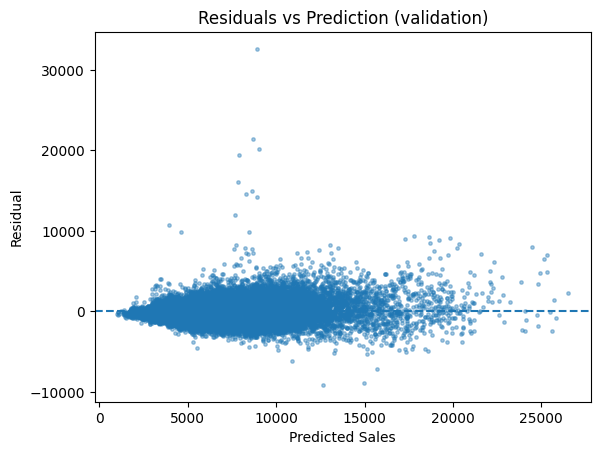

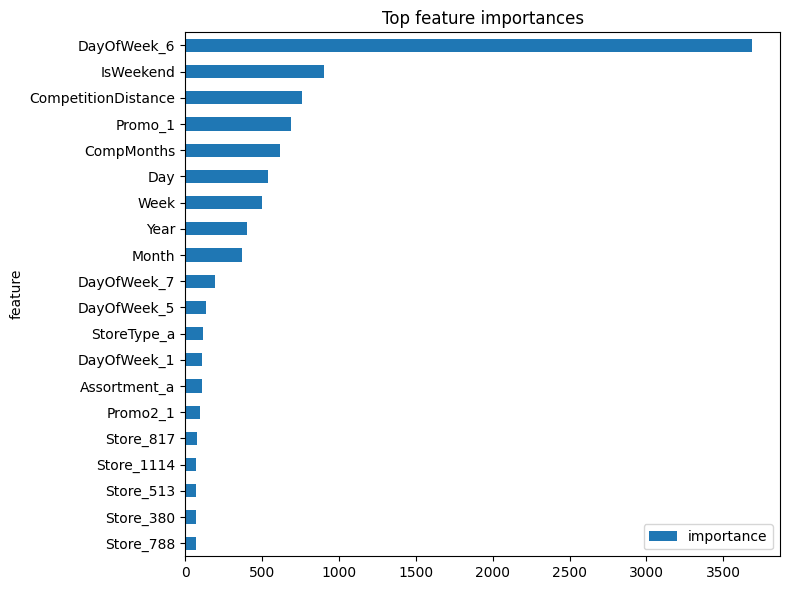

✅ Assessment visuals done


In [ ]:
resid = y_va_true - pred_va
plt.scatter(pred_va, resid, s=6, alpha=0.4)
plt.axhline(0, ls="--")
plt.title("Residuals vs Prediction (validation)")
plt.xlabel("Predicted Sales"); plt.ylabel("Residual"); plt.show()

# Feature importance (best with LGBM after one-hot)
if HAS_LGBM:
    # Get feature names after ColumnTransformer + OneHotEncoder
    ohe = pipe.named_steps["pre"].named_transformers_["cat"]
    cat_feature_names = list(ohe.get_feature_names_out(CATS))
    feature_names = cat_feature_names + NUMS
    importances = pipe.named_steps["model"].feature_importances_
    imp = (pd.DataFrame({"feature": feature_names, "importance": importances})
             .sort_values("importance", ascending=False).head(20))
    ax = imp.plot(kind="barh", x="feature", y="importance", figsize=(8,6), title="Top feature importances")
    plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()

ok("Assessment visuals done")


## Deploy

Fit on all train and build submission.csv.

In [ ]:
# Refit on all available training rows
pipe.fit(X, y)

# Predict test and back-transform
test_pred_log = pipe.predict(X_test_final)
test_pred = np.expm1(test_pred_log).clip(min=0)

sub = pd.DataFrame({"Id": test_fe["Id"].values, "Sales": test_pred})
sub.to_csv("submission.csv", index=False)

print(sub.head())
print("Saved:", os.path.abspath("submission.csv"))
expect(set(sub.columns)=={"Id","Sales"}, "Submission format incorrect")
ok("submission.csv ready")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2887
[LightGBM] [Info] Number of data points in the train set: 844392, number of used features: 1144
[LightGBM] [Info] Start training from score 8.757177
   Id        Sales
0   1  5053.610176
1   2  7544.389821
2   3  9321.302531
3   4  6248.690905
4   5  7353.544538
Saved: /content/submission.csv
✅ submission.csv ready
